In [1]:
%pylab inline
import matplotlib.pyplot as plt
np.random.seed(123)
import lasagne
import theano
import theano.tensor as T

PIXELS = ImageTools.PIXELS

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = ImageTools.prepare_MNIST()

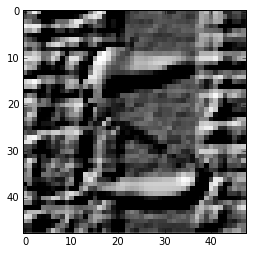

In [3]:
plt.imshow(data['X_train'][101][0], cmap='gray', interpolation='none')

In [23]:
def build_STN():

    l_in = lasagne.layers.InputLayer((None, 1, PIXELS, PIXELS))
    # l_dense1 = lasagne.layers.DenseLayer(l_in, num_units=50)
    # l_drop1 = lasagne.layers.DropoutLayer(l_dense1, p=0.5)

    # localization network
    l_conv1 = lasagne.layers.Conv2DLayer(
        l_in, 
        num_filters=16, 
        filter_size=(5,5)
    )

    l_maxpool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2,2))

    l_conv2 = lasagne.layers.Conv2DLayer(
        l_in,
        num_filters=32,
        filter_size=(3,3)
    )

    l_maxpool2 = lasagne.layers.MaxPool2DLayer(l_conv2, pool_size=(2,2))

    l_dense1 = lasagne.layers.DenseLayer(l_maxpool2, num_units=6) # transofmer layer requires 6 outputs

    # transformer network
    l_transformer = lasagne.layers.TransformerLayer(l_in, l_dense1)

    # classification network

    l_conv3 = lasagne.layers.Conv2DLayer(l_transformer,
                                        num_filters = 16,
                                        filter_size=(5,5))
    l_maxpool3 = lasagne.layers.MaxPool2DLayer(l_conv3, pool_size=(3,3))

    l_conv4 = lasagne.layers.Conv2DLayer(l_maxpool3, 
                                        num_filters=32,
                                        filter_size=(3,3))

    l_maxpool4 = lasagne.layers.MaxPool2DLayer(l_conv4, pool_size=(2,2))

    l_dense2 = lasagne.layers.DenseLayer(l_maxpool4, num_units=32)
    l_dropout1 = lasagne.layers.DropoutLayer(l_dense2, p=0.5)

    l_out = lasagne.layers.DenseLayer(l_dropout1, num_units=10)
    
    return l_out, l_transformer

In [6]:
LEARNING_RATE = 0.01

In [36]:
network = model
input_var = T.tensor4('inputs')
target_var = T.ivector('targets')
# Create a loss expression for training, i.e., a scalar objective we want
# to minimize (for our multi-class problem, it is the cross-entropy loss):
prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()
# We could add some weight decay as well here, see lasagne.regularization.

# Create update expressions for training, i.e., how to modify the
# parameters at each training step. Here, we'll use Stochastic Gradient
# Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.nesterov_momentum(
        loss, params, learning_rate=0.01, momentum=0.9)

# Create a loss expression for validation/testing. The crucial difference
# here is that we do a deterministic forward pass through the network,
# disabling dropout layers.
test_prediction = lasagne.layers.get_output(network, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                        target_var)
test_loss = test_loss.mean()
# As a bonus, also create an expression for the classification accuracy:
test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                  dtype=theano.config.floatX)

# Compile a function performing a training step on a mini-batch (by giving
# the updates dictionary) and returning the corresponding training loss:
train_fn = theano.function([input_var, target_var], loss, updates=updates, on_unused_input='ignore')

# Compile a second function computing the validation loss and accuracy:
val_fn = theano.function([input_var, target_var], [test_loss, test_acc], on_unused_input='ignore')

MissingInputError: ("An input of the graph, used to compute Shape(input), was not provided and not given a value.Use the Theano flag exception_verbosity='high',for more information on this error.", input)

In [32]:
X = T.tensor4('inputs') #inputs
Y = T.ivector('targets') #targets

model, l_transform = build_STN()

prediction = lasagne.layers.get_output(model)

loss = lasagne.objectives.categorical_crossentropy(prediction, Y)
loss = loss.mean()

model_params = lasagne.layers.get_all_params(model, trainable=True)
updates = lasagne.updates.nesterov_momentum(
    loss, model_params, learning_rate = LEARNING_RATE, momentum=0.9
)

test_prediction = lasagne.layers.get_output(model, deterministic=True)
test_loss = lasagne.objectives.categorical_crossentropy(test_prediction, Y)

test_loss = test_loss.mean()

test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), Y), dtype=theano.config.floatX)

train_fn = theano.function([X,Y], loss, updates=updates)
val_fn = theano.function([X, Y], [test_loss, test_acc])

# # output_train = lasagne.layers.get_output(model, X, deterministic=False)

# # evaluation output. Also includes output of transform for plotting
# output_eval, transform_eval = lasagne.layers.get_output([model, l_transform], X, deterministic=True)

# sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
# cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
# updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

# train = theano.function([X, y], [cost, output_train], updates=updates)
# eval = theano.function([X], [output_eval, transform_eval])

UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 0 is not part of the computational graph needed to compute the outputs: inputs.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.

In [8]:
BATCH_SIZE = 256

In [12]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['Y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_val'], data['Y_val'])
#         test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
#         test_accs += [test_acc]
        train_accs += [train_acc]

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}".format(
                n, train_cost, train_acc, valid_acc)
except KeyboardInterrupt:
    print('FAILED')
    pass

Epoch 0: Train cost nan, Train acc 0.099275, val acc 0.0961


In [15]:
X_test = np.load('./data/test_inputs.npy').reshape((-1,1,PIXELS,PIXELS))


In [16]:
output_eval, transform_eval = eval(X_test)

In [21]:
preds = np.argmax(output_eval, axis=-1)

In [22]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
transform_eval

array([[[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       [[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       [[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         ..., 
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan],
         [ nan,  nan,  nan, ...,  nan,  nan,  nan]]],


       

In [19]:
output_eval

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [18]:
import cPickle as pickle

pickle.dump(eval, open('./STN.pickle', 'w'))